# Part 1: Build CpG Detector

Here we have a simple problem, given a DNA sequence (of N, A, C, G, T), count the number of CpGs in the sequence (consecutive CGs).

We have defined a few helper functions / parameters for performing this task.

We need you to build a LSTM model and train it to complish this task in PyTorch.

A good solution will be a model that can be trained, with high confidence in correctness.

In [1]:
from typing import Sequence
from functools import partial
import random
import torch
import numpy as np
import random

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F  # Import functional layer for embedding


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# DO NOT CHANGE HERE
def set_seed(seed=13):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(13)

# Use this for getting x label
def rand_sequence(n_seqs: int, seq_len: int=128) -> Sequence[int]:
    for i in range(n_seqs):
        yield [random.randint(0, 4) for _ in range(seq_len)]

# Use this for getting y label
def count_cpgs(seq: str) -> int:
    cgs = 0
    for i in range(0, len(seq) - 1):
        dimer = seq[i:i+2]
        # note that seq is a string, not a list
        if dimer == "CG":
            cgs += 1
    return cgs

# Alphabet helpers
alphabet = 'NACGT'
dna2int = { a: i for a, i in zip(alphabet, range(5))}
int2dna = { i: a for a, i in zip(alphabet, range(5))}

intseq_to_dnaseq = partial(map, int2dna.get)
dnaseq_to_intseq = partial(map, dna2int.get)

In [4]:
# we prepared two datasets for training and evaluation
# training data scale we set to 2048
# we test on 512

def prepare_data(num_samples=100):
    # prepared the training and test data
    # you need to call rand_sequence and count_cpgs here to create the dataset
    # step 1
    X_dna_seqs_train = list(rand_sequence(num_samples))
    """
    hint:
        1. You can check X_dna_seqs_train by print, the data is ids which is your training X
        2. You first convert ids back to DNA sequence
        3. Then you run count_cpgs which will yield CGs counts - this will be the labels (Y)
    """
    #step2
    temp = ["".join(intseq_to_dnaseq(seq)) for seq in X_dna_seqs_train] # use intseq_to_dnaseq here to convert ids back to DNA seqs
    #step3
    y_dna_seqs =  [count_cpgs(seq) for seq in temp] # use count_cpgs here to generate labels with temp generated in step2

    return X_dna_seqs_train, y_dna_seqs

train_x, train_y = prepare_data(2048)
test_x, test_y = prepare_data(512)

In [5]:
# some config
LSTM_HIDDEN = 128
LSTM_LAYER = 3
batch_size = 32
learning_rate = 0.0001
epoch_num = 100

In [6]:

# Convert the training data to PyTorch tensors
train_x_tensor = torch.tensor(train_x)
print("train y ----------------",train_y)

train_y_tensor = torch.tensor(train_y).float().unsqueeze(1)  # Ensure train_y is a column vector
print("train_y_tensor======================",train_y_tensor)
# Convert the test data to PyTorch tensors
test_x_tensor = torch.tensor(test_x)
test_y_tensor = torch.tensor(test_y).float().unsqueeze(1)  # Ensure test_y is a column vector

# Create a TensorDataset
train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
test_dataset = TensorDataset(test_x_tensor, test_y_tensor)

# Create a DataLoader for the training data
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create a DataLoader for the test data
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


train y ---------------- [5, 6, 4, 4, 3, 5, 7, 8, 6, 7, 3, 6, 6, 8, 3, 3, 3, 3, 10, 4, 4, 6, 10, 6, 3, 7, 5, 0, 2, 5, 5, 5, 4, 7, 7, 5, 4, 4, 7, 2, 5, 3, 4, 4, 2, 3, 7, 7, 6, 3, 5, 4, 3, 7, 4, 6, 6, 7, 2, 7, 6, 7, 5, 5, 6, 6, 3, 6, 3, 6, 7, 3, 5, 4, 5, 4, 7, 3, 5, 2, 2, 7, 5, 2, 6, 6, 3, 5, 4, 8, 3, 4, 5, 5, 6, 5, 2, 4, 8, 5, 6, 5, 4, 2, 8, 9, 6, 2, 3, 8, 7, 4, 4, 6, 10, 6, 7, 1, 8, 5, 5, 7, 4, 3, 7, 2, 8, 7, 8, 5, 4, 4, 3, 3, 4, 7, 7, 6, 2, 5, 4, 3, 7, 8, 5, 7, 7, 5, 5, 7, 3, 8, 4, 5, 4, 5, 6, 5, 5, 7, 4, 7, 5, 6, 5, 6, 6, 5, 5, 7, 8, 6, 8, 7, 8, 4, 3, 7, 5, 3, 3, 4, 4, 3, 1, 4, 5, 10, 5, 5, 3, 7, 8, 4, 4, 4, 2, 5, 7, 8, 5, 9, 9, 7, 6, 3, 2, 4, 3, 7, 5, 12, 5, 7, 5, 4, 8, 4, 7, 2, 2, 1, 5, 5, 6, 3, 6, 3, 6, 3, 1, 5, 3, 5, 4, 6, 4, 4, 4, 5, 5, 7, 5, 5, 8, 9, 3, 5, 4, 4, 4, 2, 3, 8, 6, 5, 5, 5, 6, 8, 4, 4, 5, 1, 2, 7, 5, 6, 6, 5, 5, 5, 5, 4, 5, 1, 5, 6, 4, 10, 6, 7, 2, 5, 6, 7, 4, 7, 4, 6, 6, 3, 9, 2, 2, 7, 7, 1, 5, 3, 3, 6, 5, 4, 7, 5, 3, 3, 3, 6, 5, 6, 2, 4, 5, 4, 3, 4, 5, 7, 2, 6, 4,

In [7]:
# Model
class CpGPredictor(torch.nn.Module):
    ''' Simple model that uses a LSTM to count the number of CpGs in a sequence '''
    def __init__(self, input_size, embedding_dim, hidden_size,num_layers):
      super(CpGPredictor, self).__init__()
      self.embedding = nn.Embedding(input_size, embedding_dim)  # Define embedding layer
      # self.lstm = nn.LSTM(embedding_dim, hidden_size)
      self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
      self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # TODO complete forward function
        # Embed DNA characters
        embeddings = self.embedding(x)

        # Pass through LSTM
        lstm_out, _ = self.lstm(embeddings)

        # Get last output and predict count
        output = self.linear(lstm_out[:, -1, :])
        return output

In [8]:
# init model / loss function / optimizer etc.
model = CpGPredictor(input_size=5,embedding_dim=32, hidden_size=LSTM_HIDDEN,num_layers=LSTM_LAYER)
model

CpGPredictor(
  (embedding): Embedding(5, 32)
  (lstm): LSTM(32, 128, num_layers=3, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

In [9]:
# Loss function and optimizer
loss_fn = nn.MSELoss()  # Use Mean Squared Error loss for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Training loop
num_epochs = 100
best_val_loss = float('inf')  # Track best validation loss
patience = 5  # Set patience for early stopping
patience_counter = 0  # Counter for early stopping
for epoch in range(num_epochs):
    t_loss = 0.0
    t_correct = 0
    t_total = 0
    for x_batch, y_batch in train_data_loader:
        # Forward pass
        # print(x_batch.shape)
        # x_one_hot = nn.functional.one_hot(x_batch, num_classes=5).float()
        outputs = model(x_batch)
        loss = loss_fn(outputs, y_batch)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        t_total += y_batch.size(0)
        t_correct += (predicted == y_batch).sum().item()

    # Calculate average loss and accuracy for this epoch
    avg_loss = t_loss / len(train_data_loader)
    avg_acc = t_correct / t_total
    print(f'Training Accuracy : Epoch [{epoch+1}/{epoch_num}], Average Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f},train Loss: {loss.item()}')

    # Reset the total loss and accuracy for the next epoch
    t_loss = 0.0
    t_correct = 0
    t_total = 0

    # Print loss for each epoch
    # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    vt_correct = 0
    vt_total = 0
    with torch.no_grad():
        for x_batch, y_batch in test_data_loader:
            # x_one_hot = nn.functional.one_hot(x_batch, num_classes=5).float()
            outputs = model(x_batch)
            # outputs = model(x_batch)
            test_loss = loss_fn(outputs, y_batch)
            val_loss += test_loss.item()
            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            vt_total += y_batch.size(0)
            vt_correct += (predicted == y_batch).sum().item()
    # Calculate average loss and accuracy for this epoch
    avg_loss = val_loss / len(train_data_loader)
    avg_acc = vt_correct / vt_total
    print(f'Validation Accuracy : Epoch [{epoch+1}/{epoch_num}], Average Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f}, Test Loss: {test_loss.item()}')
    # print(f'Epoch [{epoch+1}/{epoch_num}],Test Loss: {test_loss.item()}')
    # Early stopping
    if avg_loss < best_val_loss:
        best_val_loss = avg_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch+1} due to no validation loss improvement for {patience} epochs.')
        break


Training Accuracy : Epoch [1/100], Average Loss: 23.8675, Accuracy: 0.1250,train Loss: 9.427480697631836
Validation Accuracy : Epoch [1/100], Average Loss: 1.7581, Accuracy: 0.1250, Test Loss: 5.281679630279541
Training Accuracy : Epoch [2/100], Average Loss: 4.6007, Accuracy: 0.1250,train Loss: 4.803565979003906
Validation Accuracy : Epoch [2/100], Average Loss: 1.0409, Accuracy: 0.1250, Test Loss: 4.322530746459961
Training Accuracy : Epoch [3/100], Average Loss: 4.1975, Accuracy: 0.1250,train Loss: 3.7888011932373047
Validation Accuracy : Epoch [3/100], Average Loss: 1.0391, Accuracy: 0.1250, Test Loss: 4.210931777954102
Training Accuracy : Epoch [4/100], Average Loss: 4.1989, Accuracy: 0.1250,train Loss: 2.755862236022949
Validation Accuracy : Epoch [4/100], Average Loss: 1.0407, Accuracy: 0.1250, Test Loss: 4.319737434387207
Training Accuracy : Epoch [5/100], Average Loss: 4.1950, Accuracy: 0.1250,train Loss: 4.141450881958008
Validation Accuracy : Epoch [5/100], Average Loss: 1.0

In [ ]:
# Evaluation loop
model.eval()  # Set the model to evaluation mode
res_gs = []
res_pred = []
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')

with torch.no_grad():  # Deactivate autograd for evaluation to save memory and speed up computations
    for x_batch, y_batch in test_data_loader:
        # x_one_hot = nn.functional.one_hot(x_batch, num_classes=5).float()
        # x_one_hot = x_one_hot.to(device)
        y_batch = y_batch.to(device)
        # print("batch----------",x_batch)
        outputs = model(x_batch)
        for i in range(len(x_batch)):
          print(x_batch[i],"  ",outputs[i],"  ",y_batch[i])
        res_gs.extend(y_batch.tolist())
        res_pred.extend(outputs.squeeze().tolist())
        # outputs = model(x_batch)
    test_loss = loss_fn(outputs, y_batch)
    # print("test_loss : ",test_loss)

# Convert the lists to numpy arrays for easier analysis
res_gs = np.array(res_gs)
res_pred = np.array(res_pred)

# Print the results or perform any other evaluation metrics you want


tensor([3, 3, 3, 0, 2, 3, 2, 2, 2, 0, 2, 4, 2, 4, 4, 1, 3, 3, 3, 3, 3, 1, 1, 0,
        0, 2, 1, 4, 4, 4, 0, 3, 1, 2, 4, 3, 0, 3, 4, 0, 2, 3, 4, 0, 4, 3, 2, 1,
        1, 1, 4, 1, 2, 4, 3, 0, 1, 0, 0, 4, 3, 2, 2, 3, 4, 3, 4, 1, 1, 4, 4, 1,
        4, 0, 0, 2, 3, 0, 4, 1, 2, 4, 3, 4, 4, 0, 0, 3, 2, 0, 2, 2, 1, 2, 0, 3,
        2, 2, 2, 1, 3, 0, 1, 3, 0, 4, 3, 1, 3, 0, 0, 0, 3, 0, 4, 0, 1, 3, 2, 2,
        1, 1, 2, 2, 1, 0, 3, 3])    tensor([3.8851])    tensor([4.])
tensor([3, 3, 2, 4, 3, 2, 3, 2, 0, 2, 1, 4, 2, 0, 2, 0, 2, 1, 0, 3, 4, 3, 0, 4,
        4, 3, 2, 1, 4, 1, 3, 2, 2, 2, 1, 4, 4, 0, 4, 1, 3, 2, 2, 0, 3, 3, 0, 2,
        3, 0, 0, 0, 2, 4, 4, 2, 0, 2, 4, 1, 2, 1, 0, 2, 2, 0, 2, 1, 3, 3, 1, 3,
        2, 2, 2, 0, 2, 3, 4, 4, 2, 1, 1, 1, 3, 1, 0, 2, 1, 3, 0, 0, 0, 3, 1, 4,
        4, 1, 1, 4, 3, 3, 0, 4, 1, 3, 4, 3, 0, 4, 0, 2, 3, 0, 3, 2, 2, 1, 0, 2,
        0, 4, 3, 3, 1, 1, 1, 3])    tensor([3.8185])    tensor([4.])
tensor([0, 3, 0, 4, 4, 3, 4, 0, 4, 4, 0, 4, 0, 2, 2, 2, 3, 0, 

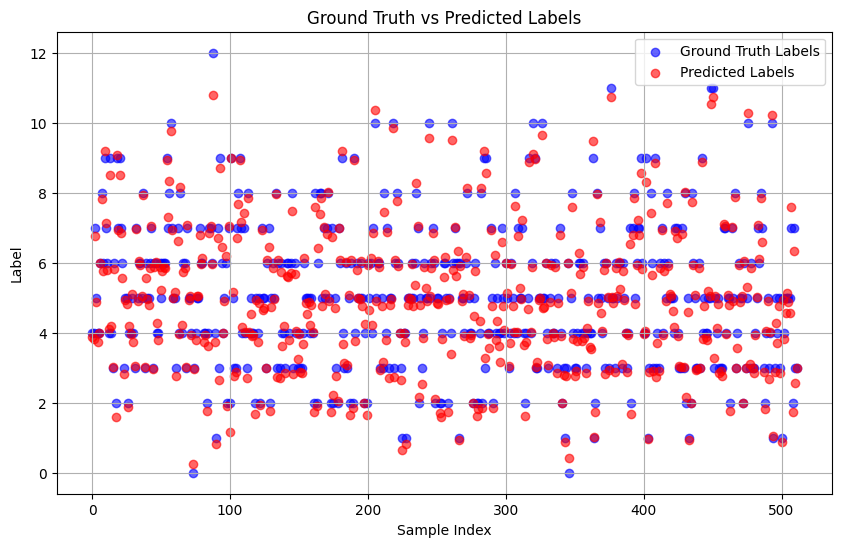

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming res_gs and res_pred are numpy arrays as mentioned
res_gs = np.array(res_gs)
res_pred = np.array(res_pred)

# Scatter plot for ground truth and predicted labels
plt.figure(figsize=(10, 6))
plt.scatter(range(len(res_gs)), res_gs, label='Ground Truth Labels', alpha=0.6, color='b')
plt.scatter(range(len(res_pred)), res_pred, label='Predicted Labels', alpha=0.6, color='r')
plt.xlabel('Sample Index')
plt.ylabel('Label')
plt.title('Ground Truth vs Predicted Labels')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate evaluation metrics
mae = mean_absolute_error(res_gs, res_pred)
mse = mean_squared_error(res_gs, res_pred)
r2 = r2_score(res_gs, res_pred)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'R-squared (R2) Score: {r2:.4f}')

Mean Absolute Error (MAE): 0.1869
Mean Squared Error (MSE): 0.0596
R-squared (R2) Score: 0.9857


In [ ]:
# Save the model
model_path = '/content/drive/MyDrive/CpG/CP_pred_emb_model.pth'
torch.save(model, model_path)

In [ ]:
state_dict = torch.load("/content/drive/MyDrive/CpG/CP_pred_emb_model.pth")
nucleotide_to_index = {'N': 0, 'A': 1, 'C': 2, 'G': 3, 'T': 4}

# Function to convert a string of nucleotides to a tensor
def string_to_tensor(s, mapping):
    # Convert the string to a list of integers
    # indices = [mapping[c] for c in s]
    indices= [2, 0, 1, 0, 4, 2, 3, 3, 0, 1, 2, 2, 0, 4, 2, 2, 3, 3, 1, 2, 0, 0, 3, 3,
        0, 4, 3, 4, 1, 4, 1, 4, 0, 2, 3, 4, 2, 0, 1, 3, 4, 4, 2, 2, 3, 1, 1, 4,
        3, 2, 2, 0, 3, 0, 0, 2, 4, 3, 4, 4, 0, 4, 0, 3, 0, 0, 4, 4, 3, 1, 3, 4,
        3, 2, 4, 3, 2, 3, 0, 0, 2, 3, 0, 3, 4, 2, 0, 2, 4, 0, 3, 2, 2, 3, 2, 4,
        4, 0, 1, 3, 3, 1, 2, 0, 4, 3, 4, 4, 2, 0, 3, 2, 4, 1, 0, 1, 4, 1, 1, 2,
        2, 4, 2, 2, 2, 0, 3, 3]
    # Convert the list to a tensor
    tensor = torch.tensor([indices])
    # One-hot encode the tensor
    # one_hot = F.one_hot(tensor, num_classes=len(mapping))
    # Add a batch dimension
    # one_hot = one_hot.unsqueeze(0).float()
    return tensor

# Test string
test_string = "CGANNCG"

# Convert the test string to a tensor
test_tensor = string_to_tensor(test_string, nucleotide_to_index)
print("test_tensor------------",test_tensor)
output = state_dict(test_tensor)
output.squeeze().tolist()

test_tensor------------ tensor([[2, 0, 1, 0, 4, 2, 3, 3, 0, 1, 2, 2, 0, 4, 2, 2, 3, 3, 1, 2, 0, 0, 3, 3,
         0, 4, 3, 4, 1, 4, 1, 4, 0, 2, 3, 4, 2, 0, 1, 3, 4, 4, 2, 2, 3, 1, 1, 4,
         3, 2, 2, 0, 3, 0, 0, 2, 4, 3, 4, 4, 0, 4, 0, 3, 0, 0, 4, 4, 3, 1, 3, 4,
         3, 2, 4, 3, 2, 3, 0, 0, 2, 3, 0, 3, 4, 2, 0, 2, 4, 0, 3, 2, 2, 3, 2, 4,
         4, 0, 1, 3, 3, 1, 2, 0, 4, 3, 4, 4, 2, 0, 3, 2, 4, 1, 0, 1, 4, 1, 1, 2,
         2, 4, 2, 2, 2, 0, 3, 3]])


7.606174945831299

# Part 2: what if the DNA sequences are not the same length

In [ ]:
import random
import torch
from typing import Sequence
from functools import partial
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

random.seed(13)

# Use this for getting x label
def rand_sequence_var_len(n_seqs: int, lb: int=16, ub: int=128) -> Sequence[int]:
    for i in range(n_seqs):
        seq_len = random.randint(lb, ub)
        yield [random.randint(1, 5) for _ in range(seq_len)]

# Use this for getting y label
def count_cpgs(seq: str) -> int:
    cgs = 0
    for i in range(0, len(seq) - 1):
        dimer = seq[i:i+2]
        # note that seq is a string, not a list
        if dimer == "CG":
            cgs += 1
    return cgs

# Alphabet helpers
alphabet = 'NACGT'
dna2int = {a: i for a, i in zip(alphabet, range(1, 6))}
int2dna = {i: a for a, i in zip(alphabet, range(1, 6))}
dna2int.update({"pad": 0})
int2dna.update({0: "<pad>"})

intseq_to_dnaseq = partial(map, int2dna.get)
dnaseq_to_intseq = partial(map, dna2int.get)

def prepare_data(num_samples=100, min_len=16, max_len=128):
    # Generate the training data
    X_dna_seqs_train = list(rand_sequence_var_len(num_samples, min_len, max_len))

    # Convert the integer sequences to DNA sequences
    temp = ["".join(intseq_to_dnaseq(seq)) for seq in X_dna_seqs_train]

    # Count the CpGs in each DNA sequence
    y_dna_seqs = [count_cpgs(seq) for seq in temp]

    # Convert the DNA sequences to integer sequences
    X_int_seqs_train = [list(dnaseq_to_intseq(seq)) for seq in temp]

    return X_int_seqs_train, y_dna_seqs

min_len, max_len = 64, 128
train_x, train_y = prepare_data(2048, min_len, max_len)
test_x, test_y = prepare_data(512, min_len, max_len)

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, lists, labels) -> None:
        self.lists = lists
        self.labels = labels

    def __getitem__(self, index):
        return self.lists[index], self.labels[index]

    def __len__(self):
        return len(self.lists)

class PadSequence:
    def __init__(self, pad_value=0):
        self.pad_value = pad_value

    def __call__(self, batch):
        # Extract sequences and labels from the batch
        sequences, labels = zip(*batch)

        # Convert sequences to tensors
        sequences = [torch.LongTensor(seq) for seq in sequences]

        # Pad the sequences to the same length (max_len)
        padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=self.pad_value)

        return padded_sequences, torch.tensor(labels, dtype=torch.float32)

train_dataset = MyDataset(train_x, train_y)
test_dataset = MyDataset(test_x, test_y)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, collate_fn=PadSequence())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, collate_fn=PadSequence())

import torch.nn as nn

class CPGCounter(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, num_layers, dropout_prob=0.2):
        super(CPGCounter, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_dim, padding_idx=0)  # Define embedding layer
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, dropout=dropout_prob, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Embed DNA characters
        embeddings = self.embedding(x)

        # Pass through LSTM
        lstm_out, _ = self.lstm(embeddings)

        # Get last output and predict count
        output = self.linear(lstm_out[:, -1, :])
        return output

LSTM_HIDDEN = 128
LSTM_LAYER = 3
learning_rate = 0.0001

model = CPGCounter(input_size=6, embedding_dim=16, hidden_size=LSTM_HIDDEN, num_layers=LSTM_LAYER, dropout_prob=0)

# Function to count the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Get the number of parameters
num_params = count_parameters(model)
print(f'The model has {num_params} trainable parameters')

loss_fn = nn.MSELoss()  # Use Mean Squared Error loss for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
num_epochs = 30  # Experiment with different training epochs
best_val_loss = float('inf')  # Track best validation loss
patience = 5  # Set patience for early stopping
patience_counter = 0  # Counter for early stopping
for epoch in range(num_epochs):
    t_loss = 0.0
    t_correct = 0
    t_total = 0
    for i, (data, target) in enumerate(train_loader):
        # Forward pass
        output = model(data)
        loss = loss_fn(output, target.float().unsqueeze(1))

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        # Calculate training accuracy
        _, predicted = torch.max(output.data, 1)
        t_total += len(target)
    avg_loss_t = t_loss / len(train_loader)
    print(f'Training Accuracy : Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss_t:.4f}, train Loss: {loss.item()}')

    # Reset the total loss and accuracy for the next epoch
    t_loss = 0.0
    t_correct = 0
    t_total = 0

    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    vt_correct = 0
    vt_total = 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            outputs = model(x_batch)
            test_loss = loss_fn(outputs, y_batch.float().unsqueeze(1))
            val_loss += test_loss.item()
            _, predicted = torch.max(outputs.data, 1)
            vt_total += y_batch.size(0)
    # Calculate average loss and accuracy for this epoch
    avg_loss = val_loss / len(test_loader)
    print(f'Validation Accuracy : Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}, Test Loss: {test_loss.item()}')
    # Early stopping
    if avg_loss < best_val_loss:
        best_val_loss = avg_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch+1} due to no validation loss improvement for {patience} epochs.')
        break


The model has 339169 trainable parameters
Training Accuracy : Epoch [1/30], Average Loss: 15.8489, train Loss: 7.150474548339844
Validation Accuracy : Epoch [1/30], Average Loss: 6.7963, Test Loss: 8.890619277954102
Training Accuracy : Epoch [2/30], Average Loss: 3.8491, train Loss: 4.5650715827941895
Validation Accuracy : Epoch [2/30], Average Loss: 3.8915, Test Loss: 5.230225563049316
Training Accuracy : Epoch [3/30], Average Loss: 3.6091, train Loss: 4.520400524139404
Validation Accuracy : Epoch [3/30], Average Loss: 3.8438, Test Loss: 5.127143383026123
Training Accuracy : Epoch [4/30], Average Loss: 3.5289, train Loss: 4.247371673583984
Validation Accuracy : Epoch [4/30], Average Loss: 3.6803, Test Loss: 4.873416900634766
Training Accuracy : Epoch [5/30], Average Loss: 3.2166, train Loss: 3.6848697662353516
Validation Accuracy : Epoch [5/30], Average Loss: 3.5032, Test Loss: 4.419884204864502
Training Accuracy : Epoch [6/30], Average Loss: 3.0997, train Loss: 3.6094281673431396
Val

In [ ]:

# Evaluation loop
model.eval()  # Set the model to evaluation mode
res_gs = []
res_pred = []

with torch.no_grad():  # Deactivate autograd for evaluation to save memory and speed up computations
    for x_batch, y_batch in test_loader:
        outputs = model(x_batch)
        res_gs.extend(y_batch.tolist())
        res_pred.extend(outputs.squeeze().tolist())
    test_loss = loss_fn(outputs, y_batch.float().unsqueeze(1))
    print("test loss : ", test_loss)


test loss :  tensor(2.0384)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate evaluation metrics
mae = mean_absolute_error(res_gs, res_pred)
mse = mean_squared_error(res_gs, res_pred)
r2 = r2_score(res_gs, res_pred)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'R-squared (R2) Score: {r2:.4f}')

Mean Absolute Error (MAE): 1.0932
Mean Squared Error (MSE): 1.8726
R-squared (R2) Score: 0.5216


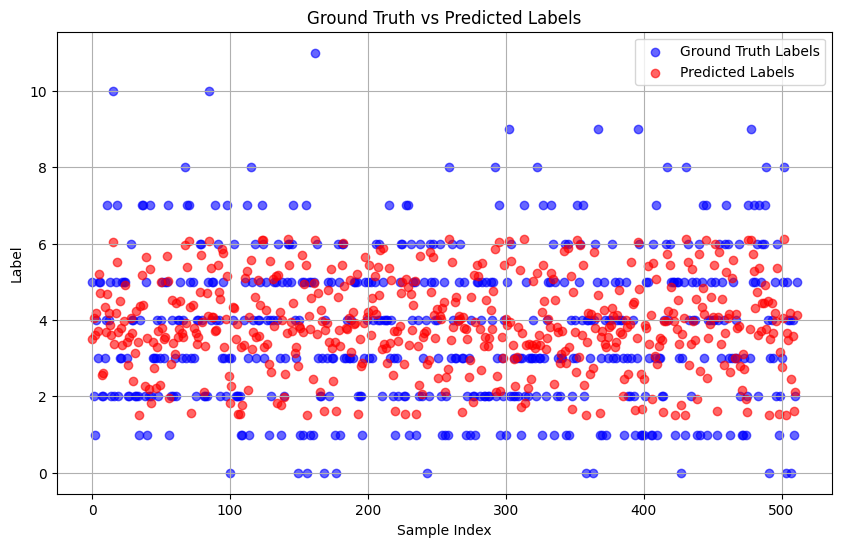

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming res_gs and res_pred are numpy arrays as mentioned
res_gs = np.array(res_gs)
res_pred = np.array(res_pred)

# Scatter plot for ground truth and predicted labels
plt.figure(figsize=(10, 6))
plt.scatter(range(len(res_gs)), res_gs, label='Ground Truth Labels', alpha=0.6, color='b')
plt.scatter(range(len(res_pred)), res_pred, label='Predicted Labels', alpha=0.6, color='r')
plt.xlabel('Sample Index')
plt.ylabel('Label')
plt.title('Ground Truth vs Predicted Labels')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

import numpy as np

res_gs = np.array(res_gs)
res_pred = np.array(res_pred)

# Save the model
model_path = '/content/drive/MyDrive/CpG/CP_count_model_padding_with_emb.pth'
torch.save(model.state_dict(), model_path)

state_dict = torch.load("/content/drive/MyDrive/CpG/CP_count_model_padding_with_emb.pth")
model.load_state_dict(state_dict)

nucleotide_to_index = {'N': 1, 'A': 2, 'C': 3, 'G': 4, 'T': 5, 'pad': 0}

# Function to convert a string of nucleotides to a tensor
def string_to_tensor(s, mapping):
    max_length = 128
    # Convert the string to a list of integers
    indices = [mapping[c] for c in s]
    print(indices)
    padding_length = max_length - len(indices)
    indices.extend([0] * padding_length)  # Pad with
    tensor = torch.LongTensor([indices])
    print("tensor-----------", tensor)
    return tensor

# Test string
test_string = "CGANCCCGCGNNNNNNNNNNNNNNNNNNNNNAAAAAAAAAAAAAAA"

# Convert the test string to a tensor
test_tensor = string_to_tensor(test_string, nucleotide_to_index)
print("test_tensor------------", test_tensor)

output = model(test_tensor)
output.squeeze().tolist()

[3, 4, 2, 1, 3, 3, 3, 4, 3, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
tensor----------- tensor([[3, 4, 2, 1, 3, 3, 3, 4, 3, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])
test_tensor------------ tensor([[3, 4, 2, 1, 3, 3, 3, 4, 3, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

1.5773165225982666